In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score, r2_score

imputer = IterativeImputer()
encoder = LabelEncoder()

In [ ]:
def stat_parity(preds, sens):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''

    # Calculate statistical parity
    prob_pos_sens_0 = np.sum((preds == 1) & (sens == 1)) / np.sum(sens == 1)
    prob_pos_sens_1 = np.sum((preds == 1) & (sens == 0)) / np.sum(sens == 0)

    statistical_parity = abs(prob_pos_sens_1 - prob_pos_sens_0)

    return statistical_parity

def eq_oppo(preds, sens, labels):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :labels: numpy array of the ground truth labels of the outcome. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    TP_1 = np.sum((preds[sens == 1] == 1) & (labels[sens == 1] == 1))
    AP_1 = np.sum(labels[sens == 1] == 1)
    TPR_sens_1 = TP_1 / AP_1

    TP_0 = np.sum((preds[sens == 0] == 1) & (labels[sens == 0] == 1))
    AP_0 = np.sum(labels[sens == 0] == 1)
    TPR_sens_0 = TP_0 / AP_0

    eq_oppo = abs(TPR_sens_1 - TPR_sens_0)

    return eq_oppo

In [ ]:
credit_df = pd.read_csv("/content/Credit.csv")
credit_df.drop(columns=['Unnamed: 0'], inplace=True)
credit_df.drop(columns=['Gender'], inplace=True)

credit_df

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,No,No,Asian,580
3,148.924,9504,681,3,36,11,No,No,Asian,964
4,55.882,4897,357,2,68,16,No,Yes,Caucasian,331
5,80.180,8047,569,4,77,10,No,No,Caucasian,1151
6,20.996,3388,259,2,37,12,No,No,African American,203
7,71.408,7114,512,2,87,9,No,No,Asian,872
8,15.125,3300,266,5,66,13,No,No,Caucasian,279
9,71.061,6819,491,3,41,19,Yes,Yes,African American,1350


In [ ]:
#credit_df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
#plt.gca().spines[['top', 'right',]].set_visible(False)

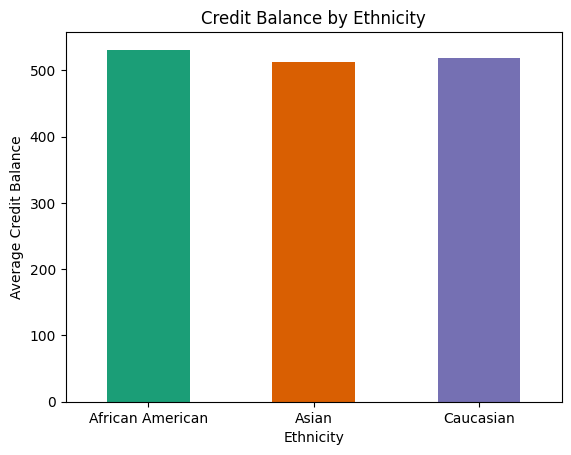

In [ ]:
ethnicity_balance_mean = credit_df.groupby('Ethnicity')['Balance'].mean()
ax = ethnicity_balance_mean.plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

plt.xlabel('Ethnicity', rotation=0)
plt.ylabel('Average Credit Balance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
_ = plt.title('Credit Balance by Ethnicity')

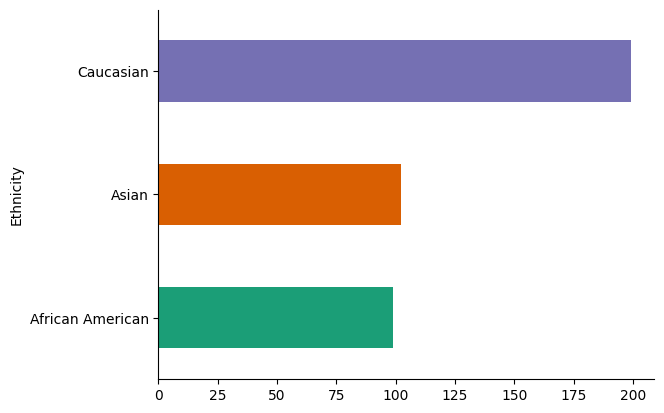

In [ ]:
credit_df.groupby('Ethnicity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
credit_df['Student'] = encoder.fit_transform(credit_df['Student'].astype(str))
credit_df['Married'] = encoder.fit_transform(credit_df['Married'].astype(str))
credit_df['Ethnicity'] = encoder.fit_transform(credit_df['Ethnicity'].astype(str))
# For Ethicity 0: African American, 1: Asian, 2: Caucasian
credit_df

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,0,1,2,333
1,106.025,6645,483,3,82,15,1,1,1,903
2,104.593,7075,514,4,71,11,0,0,1,580
3,148.924,9504,681,3,36,11,0,0,1,964
4,55.882,4897,357,2,68,16,0,1,2,331
5,80.180,8047,569,4,77,10,0,0,2,1151
6,20.996,3388,259,2,37,12,0,0,0,203
7,71.408,7114,512,2,87,9,0,0,1,872
8,15.125,3300,266,5,66,13,0,0,2,279
9,71.061,6819,491,3,41,19,1,1,0,1350


In [ ]:
X_credit = credit_df.drop(columns=['Balance'])
y_credit = credit_df['Balance']
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.3, random_state=42)

In [ ]:
df_test_senses_credit = X_credit_test['Ethnicity']
test_senses_credit = df_test_senses_credit.values

In [ ]:
#fit linear regression
lg_clf = LinearRegression()
lg_clf.fit(X_credit_train,y_credit_train)
y_pred = lg_clf.predict(X_credit_test)
print("R squared: ", r2_score(y_credit_test,y_pred))

#stat_p1 = stat_parity(y_pred, test_senses_credit)
#eq_op = eq_oppo(y_pred, test_senses_loan, test_y_adult)
#print("Statistical Parity for loan data with ethnicity label:", stat_p1)

R squared:  0.9519337432145675


In [ ]:
#fit linear regression model again without the column Ethnicity
X_credit_no_ethnicity = X_credit_train.loc[:, X_credit_train.columns != 'Ethnicity']
X_credit_test_noethnicity = X_credit_test.loc[:, X_credit_test.columns != 'Ethnicity']

lg_clf = LinearRegression()
lg_clf.fit(X_credit_no_ethnicity,y_credit_train)
y_pred = lg_clf.predict(X_credit_test_noethnicity)
print("R Squared: ", r2_score(y_credit_test,y_pred))

#stat_p2 = stat_parity(y_pred, test_senses_credit)
#eq_op = eq_oppo(y_pred, test_senses_loan, test_y_adult)
#print("Statistical Parity for loan data with ethnicity label:", stat_p2)

R Squared:  0.9521835034978982


In [ ]:
loan_df = pd.read_csv("/content/train.csv")
loan_df.drop(columns=['Loan_ID'], inplace=True)
loan_df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.000000,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.000000,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.000000,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.000000,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.000000,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.000000,267.0,360.0,1.0,Urban,Y
6,Male,Yes,0,Not Graduate,No,2333,1516.000000,95.0,360.0,1.0,Urban,Y
7,Male,Yes,3+,Graduate,No,3036,2504.000000,158.0,360.0,0.0,Semiurban,N
8,Male,Yes,2,Graduate,No,4006,1526.000000,168.0,360.0,1.0,Urban,Y
9,Male,Yes,1,Graduate,No,12841,10968.000000,349.0,360.0,1.0,Semiurban,N


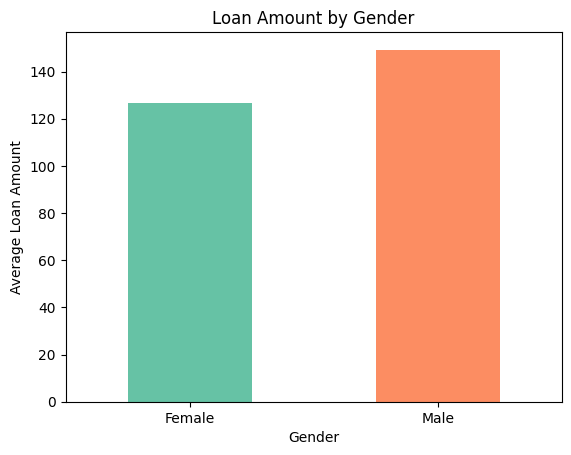

In [ ]:
gender_amount_mean = loan_df.groupby('Gender')['LoanAmount'].mean()
ax = gender_amount_mean.plot(kind='bar', color=sns.palettes.mpl_palette('Set2'))
plt.xlabel('Gender')
plt.ylabel('Average Loan Amount')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
_ = plt.title('Loan Amount by Gender')

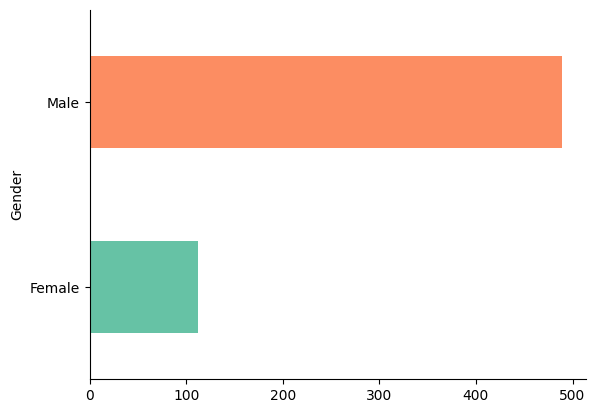

In [ ]:
loan_df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Set2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
loan_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [ ]:
loan_df['Gender'] = encoder.fit_transform(loan_df['Gender'].astype(str))
loan_df['Married'] = encoder.fit_transform(loan_df['Married'].astype(str))
loan_df['Education'] = encoder.fit_transform(loan_df['Education'].astype(str))
loan_df['Self_Employed'] = encoder.fit_transform(loan_df['Self_Employed'].astype(str))
loan_df['Property_Area'] = encoder.fit_transform(loan_df['Property_Area'].astype(str))
loan_df['Loan_Status'] = encoder.fit_transform(loan_df['Loan_Status'].astype(str))


columns_to_impute = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
imputer.fit(loan_df[columns_to_impute])
df_imputed = pd.DataFrame(imputer.transform(loan_df[columns_to_impute]), columns=columns_to_impute)

#gender_map = {0: 'Female', 1: 'Male'}
#loan_df['Gender'] = loan_df['Gender'].map(gender_map)

#married_map = {0: 'No', 1: 'Yes'}
#loan_df['Married'] = loan_df['Married'].map(married_map)

#Education_map = {0: 'Graduate', 1: 'Not Graduate'}
#loan_df['Education'] = loan_df['Education'].map(Education_map)

#Self_Employed_map = {0: 'No', 1: 'Yes'}
#loan_df['Self_Employed'] = loan_df['Self_Employed'].map(Self_Employed_map)

#Property_Area_map = {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}
#loan_df['Property_Area'] = loan_df['Property_Area'].map(Property_Area_map)

#Loan_Status_map = {0: 'No', 1: 'Yes'}
#loan_df['Loan_Status'] = loan_df['Loan_Status'].map(Loan_Status_map)

loan_df['ApplicantIncome'].fillna(loan_df['ApplicantIncome'].mean(), inplace=True)
loan_df['CoapplicantIncome'].fillna(loan_df['CoapplicantIncome'].mean(), inplace=True)
loan_df['LoanAmount'].fillna(loan_df['LoanAmount'].mean(), inplace=True)
loan_df['Loan_Amount_Term'].fillna(loan_df['Loan_Amount_Term'].mean(), inplace=True)

loan_df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.000000,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.000000,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.000000,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.000000,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.000000,141.000000,360.0,1.0,2,1
5,1,1,2,0,1,5417,4196.000000,267.000000,360.0,1.0,2,1
6,1,1,0,1,0,2333,1516.000000,95.000000,360.0,1.0,2,1
7,1,1,3+,0,0,3036,2504.000000,158.000000,360.0,0.0,1,0
8,1,1,2,0,0,4006,1526.000000,168.000000,360.0,1.0,2,1
9,1,1,1,0,0,12841,10968.000000,349.000000,360.0,1.0,1,0


In [ ]:
loan_df.loc[loan_df['Dependents'] == '3+', 'Dependents'] = 3
loan_df['Dependents'].fillna(0, inplace=True)
loan_df['Credit_History'].fillna(0, inplace=True)
loan_df


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.000000,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.000000,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.000000,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.000000,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.000000,141.000000,360.0,1.0,2,1
5,1,1,2,0,1,5417,4196.000000,267.000000,360.0,1.0,2,1
6,1,1,0,1,0,2333,1516.000000,95.000000,360.0,1.0,2,1
7,1,1,3,0,0,3036,2504.000000,158.000000,360.0,0.0,1,0
8,1,1,2,0,0,4006,1526.000000,168.000000,360.0,1.0,2,1
9,1,1,1,0,0,12841,10968.000000,349.000000,360.0,1.0,1,0


In [ ]:
nan_in_column = loan_df['Property_Area'].isna().all()
if nan_in_column:
    print("There are NaN values in the column.")
else:
    print("There are no NaN values in the column.")


There are no NaN values in the column.


In [ ]:
#train test split
y_loan = loan_df['Loan_Status']
X_loan = loan_df.drop(columns=['Loan_Status'])
X_loan_train, X_loan_test, y_loan_train, y_loan_test = train_test_split(X_loan, y_loan, test_size=0.3, random_state=42)

In [ ]:
df_test_senses_loan = X_loan_test['Gender']
test_senses_loan = df_test_senses_loan.values

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_loan_train,y_loan_train)
y_pred = rf_clf.predict(X_loan_test)
print("Train Accuracy ", accuracy_score(y_loan_test,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_loan_train,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_loan_train,y_loan_train,cv=5,scoring='accuracy').mean())

stat_p1 = stat_parity(y_pred, test_senses_loan)
#eq_op = eq_oppo(y_pred, test_senses_loan, test_y_adult)
print("Statistical Parity for loan data with gender label:", stat_p1)

Train Accuracy  0.6918918918918919
Validation Mean F1 Score:  0.5546970905298696
Validation Mean Accuracy:  0.7063474692202463
Statistical Parity for loan data with gender label: 0.007373271889400956


In [ ]:
#drop Gender column and fit the model again
X_loan_no_gender = X_loan_train.loc[:, X_loan_train.columns != 'Gender']
X_loan_test_nogender = X_loan_test.loc[:, X_loan_test.columns != 'Gender']

rf_clf2 = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf2.fit(X_loan_no_gender,y_loan_train)
y_pred = rf_clf2.predict(X_loan_test_nogender)
print("Train Accuracy ", accuracy_score(y_loan_test,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf2,X_loan_no_gender,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf2,X_loan_no_gender,y_loan_train,cv=5,scoring='accuracy').mean())
stat_p2 = stat_parity(y_pred, test_senses_loan)
print("Statistical Parity for loan data without gender label:", stat_p2)

Train Accuracy  0.7243243243243244
Validation Mean F1 Score:  0.602716792407924
Validation Mean Accuracy:  0.7296306429548564
Statistical Parity for loan data without gender label: 0.0055299539170506895
